In [5]:
import sys, platform
print("Kernel Python:", sys.version)
print("Kernel executable:", sys.executable)
print("Platform:", platform.platform())


Kernel Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Kernel executable: /usr/bin/python3.real
Platform: Linux-6.6.105+-x86_64-with-glibc2.35


In [6]:

# This installs a conda layer into Colab and switches the runtime environment.
# It usually triggers a runtime restart automatically.
!pip -q install condacolab
import condacolab
condacolab.install()


✨🍰✨ Everything looks OK!


In [2]:
!pip -q install condacolab
import condacolab
condacolab.install()


✨🍰✨ Everything looks OK!


In [3]:
import condacolab
condacolab.check()

!conda install -y -c conda-forge rdkit pandas numpy scipy matplotlib seaborn

print("Conda packages installed.")


✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Conda packages installed.


In [4]:

# This uses conda's python directly, bypassing the notebook kernel's broken rdkit.
!CONDA_PY="$(conda info --base)/bin/python" && \
"$CONDA_PY" -c "from rdkit import Chem; import rdkit; print('RDKit OK from conda:', rdkit.__version__)"


RDKit OK from conda: 2025.09.4


In [5]:
!pip -q install chembl_webresource_client

import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client

print("ChEMBL client OK")


ChEMBL client OK


In [11]:
keyword = "coronavirus"  # try also: "acetylcholinesterase", "aromatase"
targets = new_client.target.search(keyword)
targets_df = pd.DataFrame.from_records(targets)

print("Targets found:", len(targets_df))
cols = [c for c in ["target_chembl_id", "pref_name", "organism", "target_type"] if c in targets_df.columns]
targets_df[cols].head(10)


Targets found: 14


,target_chembl_id,pref_name,organism,target_type
0,CHEMBL613732,Coronavirus,Coronavirus,ORGANISM
1,CHEMBL613732,Coronavirus,Coronavirus,ORGANISM
2,CHEMBL612744,Feline coronavirus,Feline coronavirus,ORGANISM
3,CHEMBL5209664,Murine coronavirus,Murine coronavirus,ORGANISM
4,CHEMBL5291668,Canine coronavirus,Canine coronavirus,ORGANISM
5,CHEMBL6066646,Bovine coronavirus,Bovine coronavirus,ORGANISM
6,CHEMBL613837,Human coronavirus 229E,Human coronavirus 229E,ORGANISM
7,CHEMBL5209665,Human coronavirus OC43,Human coronavirus OC43,ORGANISM
8,CHEMBL4296578,Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,ORGANISM
9,CHEMBL3927,Replicase polyprotein 1a,Severe acute respiratory syndrome-related coro...,SINGLE PROTEIN


In [14]:
targets_df.head(6)

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
2,[],Feline coronavirus,Feline coronavirus,15.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Murine coronavirus,Murine coronavirus,15.0,False,CHEMBL5209664,[],ORGANISM,694005
4,[],Canine coronavirus,Canine coronavirus,15.0,False,CHEMBL5291668,[],ORGANISM,11153
5,[],Bovine coronavirus,Bovine coronavirus,15.0,False,CHEMBL6066646,[],ORGANISM,11128


In [60]:
selected_idx = 9  # change after you inspect targets_df
row = targets_df.iloc[selected_idx]
target_chembl_id = row["target_chembl_id"]
print("Selected:", row.get("pref_name"), "|", target_chembl_id, "|", row.get("target_type"))


Selected: Replicase polyprotein 1a | CHEMBL3927 | SINGLE PROTEIN


In [61]:
activities = new_client.activity.filter(
    target_chembl_id=target_chembl_id,
    standard_type="IC50",
    standard_units="nM"
)
act_df = pd.DataFrame.from_records(activities)
print("Raw rows:", len(act_df))
act_df.head(3)


Raw rows: 260


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,Replicase polyprotein 1a,694009,None,None,IC50,uM,UO_0000065,None,7.2
1,None,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,Replicase polyprotein 1a,694009,None,None,IC50,uM,UO_0000065,None,7.2
2,None,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome-related coro...,Replicase polyprotein 1a,694009,None,None,IC50,uM,UO_0000065,None,9.4


In [62]:
df = act_df[["molecule_chembl_id", "canonical_smiles", "standard_value"]].copy()

df = df.dropna(subset=["molecule_chembl_id", "canonical_smiles", "standard_value"])
df["standard_value"] = pd.to_numeric(df["standard_value"], errors="coerce")
df = df.dropna(subset=["standard_value"])
df = df[df["standard_value"] > 0].copy()

print("After cleaning rows:", len(df))
df.head()


After cleaning rows: 260


,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0
1,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0
2,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0
3,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0
4,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0


In [63]:
df = df.sort_values("standard_value", ascending=True)
df = df.drop_duplicates(subset=["molecule_chembl_id"], keep="first").reset_index(drop=True)

print("After dedup rows:", len(df))
df.describe()


After dedup rows: 197


,standard_value
count,1.970000e+02
mean,5.477617e+04
std,1.840548e+05
min,1.400000e+01
25%,2.200000e+03
50%,1.257000e+04
75%,4.000000e+04
max,2.000000e+06


In [64]:
def label_activity(ic50_nm: float) -> str:
    if ic50_nm < 1000:
        return "active"
    elif ic50_nm > 10000:
        return "inactive"
    else:
        return "intermediate"

df["bioactivity_class"] = df["standard_value"].apply(label_activity)
df["bioactivity_class"].value_counts()


,count
bioactivity_class,
inactive,110
intermediate,47
active,40


In [65]:
out_part1 = "bioactivity_curated_part1.csv"
df.to_csv(out_part1, index=False)
print("Saved:", out_part1)

Saved: bioactivity_curated_part1.csv


In [66]:
# This cell runs a small Python script using conda python.
# It reads bioactivity_curated_part1.csv, computes descriptors, pIC50, filters 2-class, and writes output CSV.

script = r'''
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski

inp = "bioactivity_curated_part1.csv"
out = "bioactivity_with_descriptors_part2.csv"

df = pd.read_csv(inp)

# RDKit Mol
mols = []
bad = 0
for smi in df["canonical_smiles"].astype(str):
    m = Chem.MolFromSmiles(smi)
    if m is None:
        bad += 1
    mols.append(m)

df["mol"] = mols
df = df.dropna(subset=["mol"]).reset_index(drop=True)

# Descriptors
df["MW"]   = df["mol"].apply(Descriptors.MolWt)
df["LogP"] = df["mol"].apply(Crippen.MolLogP)
df["HBD"]  = df["mol"].apply(Lipinski.NumHDonors)
df["HBA"]  = df["mol"].apply(Lipinski.NumHAcceptors)

# pIC50
df["IC50_nM"] = df["standard_value"].astype(float)
df["pIC50"] = -np.log10(df["IC50_nM"] * 1e-9)

# 2-class subset
df2 = df[df["bioactivity_class"].isin(["active","inactive"])].copy()

# Drop mol column before saving
df2 = df2.drop(columns=["mol"])

df2.to_csv(out, index=False)
print("Bad SMILES dropped:", bad)
print("Saved:", out, "rows:", len(df2), "cols:", df2.shape[1])
'''

# Write the script to a file
with open("run_rdkit_part2.py", "w", encoding="utf-8") as f:
    f.write(script)

# Run using conda python
!CONDA_PY="$(conda info --base)/bin/python" && "$CONDA_PY" run_rdkit_part2.py


Bad SMILES dropped: 0
Saved: bioactivity_with_descriptors_part2.csv rows: 150 cols: 10


(150, 10)


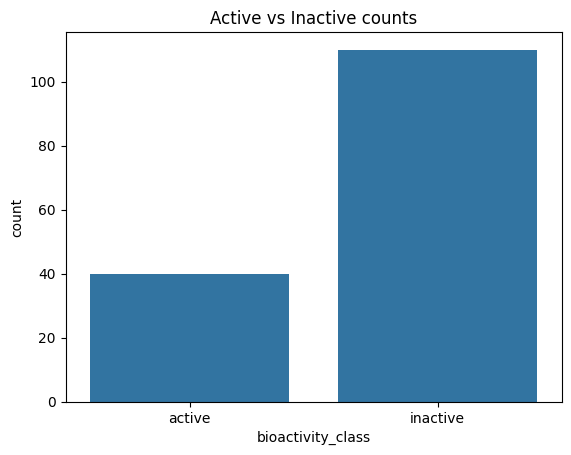

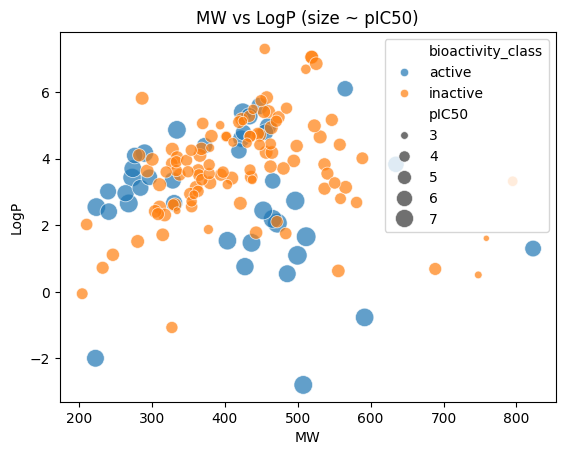

,feature,U_stat,p_value,n_active,n_inactive
0,pIC50,4400.0,8.598572e-21,40,110
4,HBA,1557.0,5.598275e-03,40,110
2,LogP,1669.5,2.429448e-02,40,110
3,HBD,1982.5,3.391821e-01,40,110
1,MW,2025.5,4.596150e-01,40,110


In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

df2 = pd.read_csv("bioactivity_with_descriptors_part2.csv")
print(df2.shape)
df2.head()

# Counts
plt.figure()
sns.countplot(data=df2, x="bioactivity_class")
plt.title("Active vs Inactive counts")
plt.show()

# Scatter: MW vs LogP, size by pIC50
plt.figure()
sns.scatterplot(
    data=df2, x="MW", y="LogP",
    hue="bioactivity_class",
    size="pIC50", sizes=(20, 200),
    alpha=0.7
)
plt.title("MW vs LogP (size ~ pIC50)")
plt.show()

# Boxplots + Mann–Whitney U
def mw(feature):
    a = df2[df2["bioactivity_class"]=="active"][feature].values
    b = df2[df2["bioactivity_class"]=="inactive"][feature].values
    stat, p = mannwhitneyu(a, b, alternative="two-sided")
    return stat, p, len(a), len(b)

results = []
for feat in ["pIC50","MW","LogP","HBD","HBA"]:
    stat, p, na, nb = mw(feat)
    results.append({"feature": feat, "U_stat": stat, "p_value": p, "n_active": na, "n_inactive": nb})

pd.DataFrame(results).sort_values("p_value")
